## Plot main results

In [1]:
import lzma
import pickle
import matplotlib.pyplot as plt
import numpy as np
from multireward_ope.tabular.envs.make_env import make_env
from multireward_ope.tabular.reward_set import RewardSetRewardFree
import preamble_figures
import pandas as pd
import seaborn as sns
from multireward_ope.tabular.dataclasses import Config
from multireward_ope.tabular.agents.make_agent import make_agent
from multireward_ope.tabular.agents.dataclasses import AgentParameters
from scipy.stats import bootstrap

In [2]:
colors = {
    'SF-NR_': 'forestgreen',
    'GVFExplorer_':'black',#'#00bfc4',#'mediumorchid',#
    'MR-NaS-PE_500_False':'#f8766d',
    'Noisy-Policy_Uniform_0.3':'royalblue',
    'Noisy-Policy_Visitation based_0.3': 'firebrick',#'#3B3B3B',
}

name_map = {
    'SF-NR_': 'SF-NR',
    'GVFExplorer_': 'GVFExplorer',
    'MR-NaS-PE_500_False': 'MR-NaS',
    'Noisy-Policy_Uniform_0.3': 'Noisy Policy (unif.)' ,
    'Noisy-Policy_Visitation based_0.3': 'Noisy Policy (visit.)'
}

def get_envs(size: str):
    if size == 'small':
        envs =  [('Riverswim',15),('ForkedRiverswim',8),('DoubleChain',17),('NArms',15)]
    elif size == 'medium':
        envs =  [('Riverswim',20),('ForkedRiverswim',10),('DoubleChain',21),('NArms',20)]
    elif size =='large':
        envs =  [('Riverswim',30),('ForkedRiverswim',15),('DoubleChain',31),('NArms',30)]
    else:
        print(f'Error! No size {size}')
    return envs
HORIZON = 1000000

In [3]:
def get_data(dir: str, envs: list, debug: bool = False):
    data = {}
    for env, N in envs:
        results = []
        for agent in name_map.keys():
            filename = f'{HORIZON}_{env}_{N}_{agent}.lzma'
            if debug: print(f'Loading {filename}')
            try:
                with lzma.open(f'./data/tabular/{dir}/{filename}', 'rb') as f:
                    res = pickle.load(f)
                    results.append((agent, res))
            except Exception as e:
                if debug: print(e)
                continue
            data[env] = results
    return data


Problem size: small
Data type: Finite_MultiplePolicies
-----------------------------------
Data type: RewardFree_MultiplePolicies
-----------------------------------
Data type: RewardFree_SinglePolicy
-----------------------------------
Problem size: medium
Data type: Finite_MultiplePolicies
-----------------------------------
Data type: RewardFree_MultiplePolicies
-----------------------------------
Data type: RewardFree_SinglePolicy
-----------------------------------
Problem size: large
Data type: Finite_MultiplePolicies
-----------------------------------
Data type: RewardFree_MultiplePolicies
-----------------------------------
Data type: RewardFree_SinglePolicy
-----------------------------------


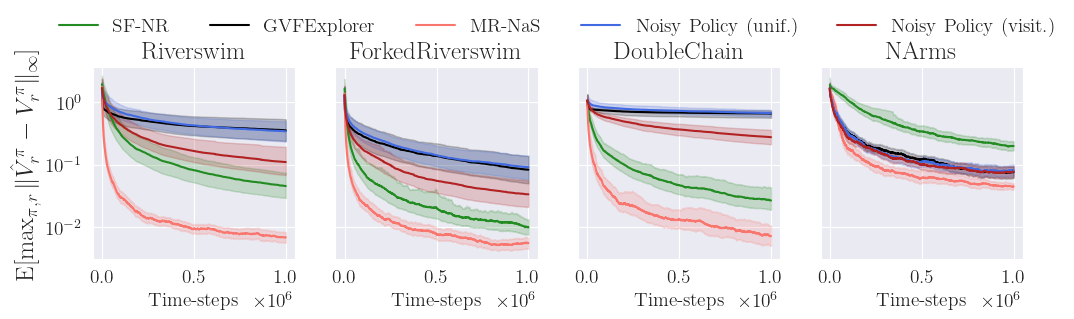

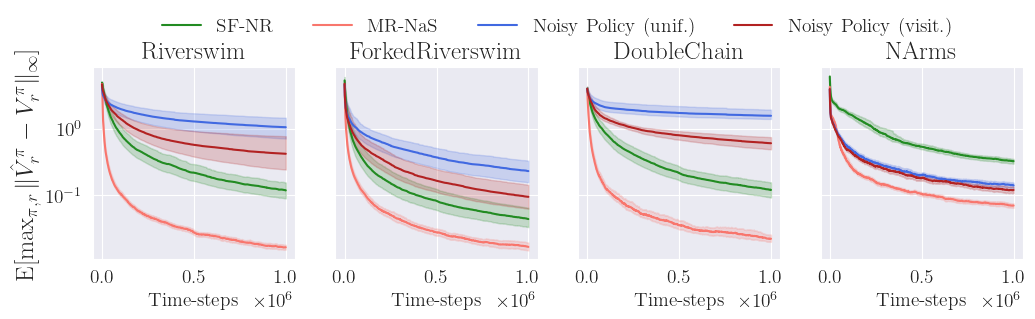

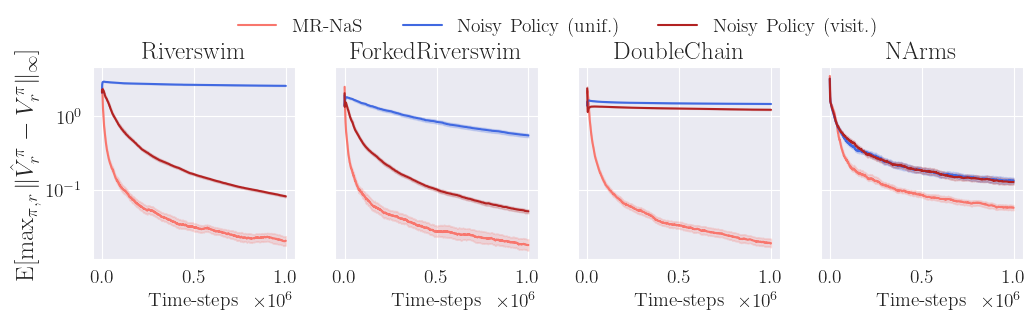

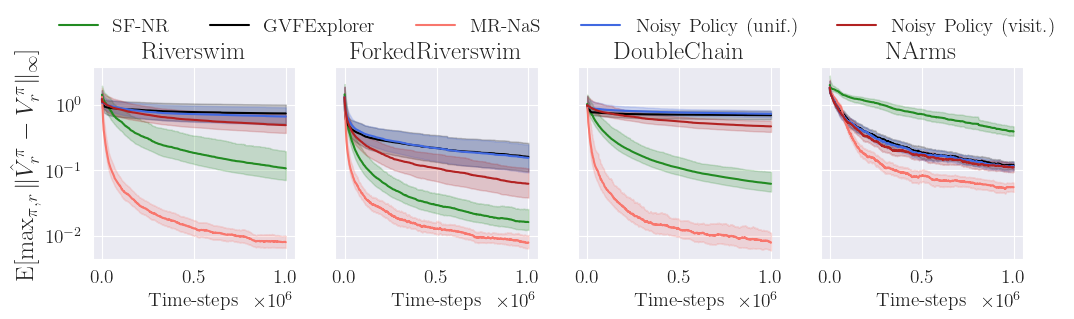

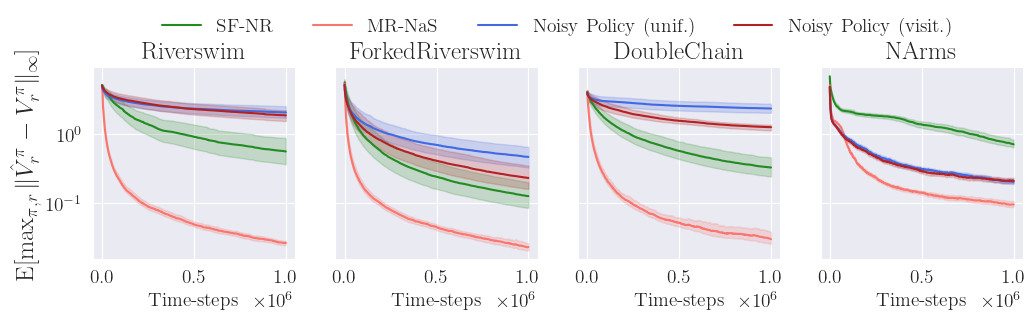

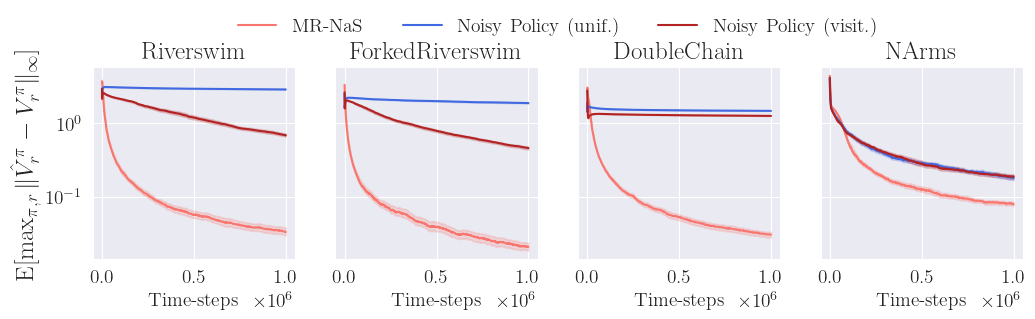

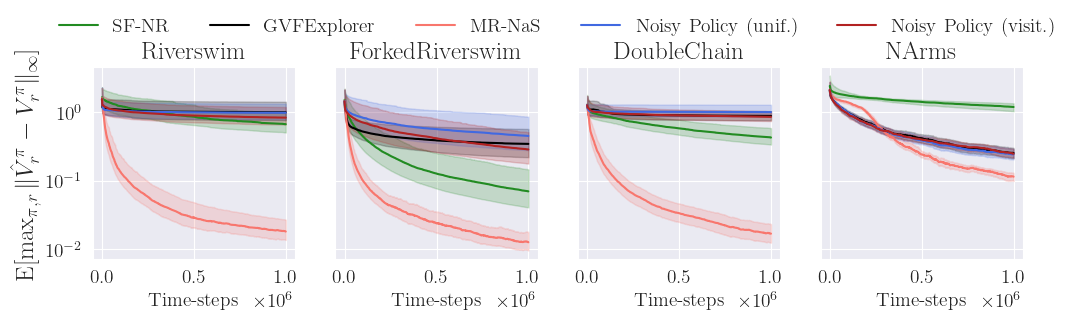

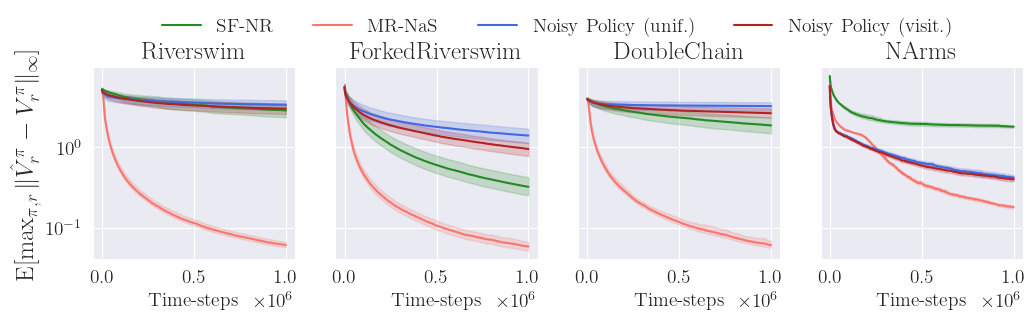

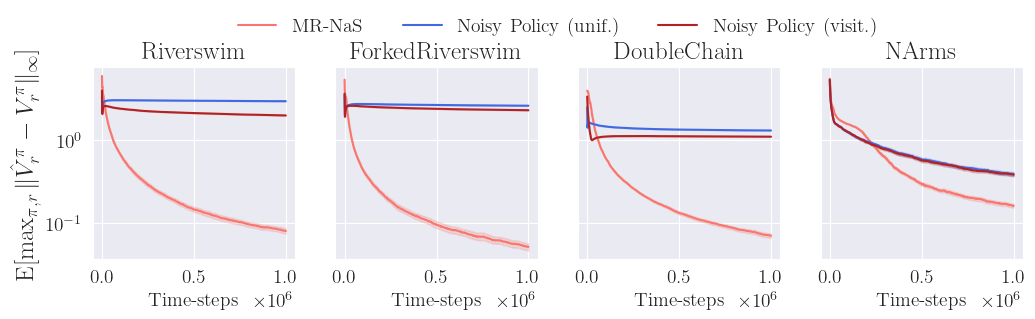

In [4]:
filenames = [('Finite_MultiplePolicies', 'multi_policy_multi_reward_abs_error'),
             ('RewardFree_MultiplePolicies', 'multi_policy_rewfree_abs_error'),
             ('RewardFree_SinglePolicy', 'single_policy_rewfree_abs_error')]

for size in ['small', 'medium', 'large']:
    print(f'Problem size: {size}')
    envs = get_envs(size)
    for data_name, fname in filenames:
        fig, ax = plt.subplots(1,4, sharey=True, figsize=(12,2.5))
        print(f'Data type: {data_name}')
        data = get_data(data_name, envs)
        idx = 0

        for env, N in envs:
            
            for agent_name, res in data[env]:
                err_rel = res['abs_results'] 
                errors = np.linalg.norm(err_rel, ord=np.inf, axis=-1).max(-1)
                xvalues = np.arange(errors.shape[1]) * 500
                res = bootstrap((errors,), np.mean, confidence_level=0.95)
                ax[idx].plot(xvalues, errors.mean(0), color=colors[agent_name], label=name_map[agent_name])
                ax[idx].fill_between(xvalues, res.confidence_interval.low, res.confidence_interval.high, color=colors[agent_name], alpha=0.2)

            ax[idx].set_yscale('log')
            ax[idx].set_title(env)
            ax[idx].set_xlabel('Time-steps')
            ax[idx].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            
            idx+=1
        ax[0].set_ylabel(r'${\rm E}[\max_{\pi,r} \|\hat V_r^\pi - V_r^\pi\|_\infty]$',fontsize=18)
        ax[0].legend(loc='upper center', bbox_to_anchor=(2.3, 1.3), borderaxespad=0, ncol=5, frameon=False)

        plt.savefig(f"figures/{HORIZON}_{fname}_{size}.pdf", bbox_inches='tight')
        print('-----------------------------------')